In [52]:
from bot import get_historical_data
import pandas as pd
from binance.client import Client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, make_scorer, precision_score
from itertools import combinations
from xgboost import XGBClassifier

In [53]:
TRANSACTION_COSTS = 0.0005
# Start investment is EURO!

In [54]:
# Fetch Bitcoin prices at 5-minute intervals for the last 40 days
symbol = 'BTCEUR'
days = 10000

bitcoin_data_hour = get_historical_data(symbol, Client.KLINE_INTERVAL_1HOUR, days)
#bitcoin_data_5minute = get_historical_data(symbol, Client.KLINE_INTERVAL_5MINUTE, days)

In [55]:
bitcoin_data_hour["Open time"]

0       2020-01-03 09:00:00+01:00
1       2020-01-03 10:00:00+01:00
2       2020-01-03 11:00:00+01:00
3       2020-01-03 12:00:00+01:00
4       2020-01-03 13:00:00+01:00
                   ...           
40413   2024-08-14 15:00:00+02:00
40414   2024-08-14 16:00:00+02:00
40415   2024-08-14 17:00:00+02:00
40416   2024-08-14 18:00:00+02:00
40417   2024-08-14 19:00:00+02:00
Name: Open time, Length: 40418, dtype: datetime64[ns, Europe/Berlin]

In [56]:
bitcoin_data_hour.shape

(40418, 12)

In [57]:
bitcoin_data_hour["pct"] = bitcoin_data_hour["Close"].pct_change().shift(-1)    #time shift ist WICHTIG! einer der häufigsten Fehler, wenn er vergessen wird
#bitcoin_data_5minute["pct"] = bitcoin_data_5minute["Close"].pct_change().shift(-1)

In [58]:
bitcoin_data_hour.dropna(inplace=True)
#bitcoin_data_5minute.dropna(inplace=True)

df_hour = bitcoin_data_hour
#df_5minute = bitcoin_data_5minute


In [59]:
def sharpe_ratio(s):
    s = np.log(1+s)
    sharpe = s.mean() / s.std()
    print(f"mean={s.mean():.6f}, std={s.std():.6f}")
    return sharpe

In [60]:
#Funktion um zu zählen wie häufig ein buy Signal hinter einander auftritt
def count_consecutive_ones(data: pd.DataFrame, signal_col: str):
    new_column_name = signal_col + "_count"
    
    count = 0
    counts = []
    
    for value in data[signal_col]:
        if value == 1:
            count += 1
        else:
            count = 0
        counts.append(count)
    
    data[new_column_name] = counts

### Indikatoren und Indexe berechnen

In [61]:
def OBV_berechnen(data:pd.DataFrame):
    #benötigt ein DataFrame mit den Spalten "4a. close (EUR)" und "5. volume"
    data["OBV"] = (np.sign(data["Close"].pct_change()) * data["Volume"]).cumsum()
    
def SMA_berechnen(data:pd.DataFrame, intervall:int):
    spalten_name = "SMA_"+str(intervall)
    data[spalten_name] = data["Close"].rolling(intervall).mean()
    spalten_name_sig = "SMA_"+str(intervall)+"_Sig"
    data[spalten_name_sig] = (data["Close"]>data[spalten_name]).astype(int)
    print(data[spalten_name_sig].mean())
    count_consecutive_ones(data, spalten_name_sig)
    
def RSI_berechnen(data:pd.DataFrame, intervall:int):

    spalten_name = "RSI_"+str(intervall)

    # Bestimme die Preisänderung zum jeweiligen Zeitpunkt t-1
    delta = data["Close"].diff()

    # Get rid of the first row, which has NaN values
    delta = delta[1:]

    # Calculate the gains and losses
    up = delta.where(delta > 0, 0)
    down = -delta.where(delta < 0, 0)

    # Calculate the rolling average of the gains and losses
    #window_size = 14 #als default
    avg_gain = up.rolling(intervall).mean()
    avg_loss = down.rolling(intervall).mean()

    # Calculate the relative strength
    rs = avg_gain / avg_loss

    # Calculate the RSI
    data[spalten_name] = 100 - (100 / (1 + rs))
    
def EMA_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "EMA_" + str(intervall)
    data[spalten_name] = data["Close"].ewm(span=intervall, adjust=False).mean()
    spalten_name_sig = "EMA_"+str(intervall)+"_Sig"
    data[spalten_name_sig] = (data["Close"]>data[spalten_name]).astype(int)
    count_consecutive_ones(data, spalten_name_sig)

def HMA_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "HMA_" + str(intervall)
    half_length = int(intervall / 2)
    sqrt_length = int(np.sqrt(intervall))

    wma_half = data["Close"].rolling(window=half_length).mean()
    wma_full = data["Close"].rolling(window=intervall).mean()

    raw_hma = 2 * wma_half - wma_full
    data[spalten_name] = raw_hma.rolling(window=sqrt_length).mean()
    
    spalten_name_sig = "HMA_"+str(intervall)+"_Sig"
    data[spalten_name_sig] = (data["Close"]>data[spalten_name]).astype(int)
    count_consecutive_ones(data, spalten_name_sig)

def MACD_berechnen(data: pd.DataFrame, fast_period: int = 12, slow_period: int = 26, signal_period: int = 9):
    data["MACD"] = data["Close"].ewm(span=fast_period, adjust=False).mean() - data["Close"].ewm(span=slow_period, adjust=False).mean()
    data["MACD_Signal"] = data["MACD"].ewm(span=signal_period, adjust=False).mean()

def Momentum_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "Momentum_" + str(intervall)
    data[spalten_name] = data["Close"].diff(intervall)

def Stochastic_RSI_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "StochRSI_" + str(intervall)

    delta = data["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=intervall).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=intervall).mean()

    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))

    min_RSI = RSI.rolling(window=intervall).min()
    max_RSI = RSI.rolling(window=intervall).max()

    data[spalten_name] = (RSI - min_RSI) / (max_RSI - min_RSI)

In [62]:
indicators = []
dt_indicators = []
OBV_berechnen(df_hour)
MACD_berechnen(df_hour)
dt_indicators.extend([f'OBV', f'MACD'])
for i in [24, 24*7, 24*30]:#[5, 10, 20, 50, 100, 500, 1000]:
    SMA_berechnen(df_hour, i)
    RSI_berechnen(df_hour, i)
    EMA_berechnen(df_hour, i)
    HMA_berechnen(df_hour, i)
    Momentum_berechnen(df_hour, i)
    Stochastic_RSI_berechnen(df_hour, i)
    indicators.extend([f"RSI_{i}", f"EMA_{i}", f"HMA_{i}", f"Momentum_{i}", f"StochRSI_{i}"])
    dt_indicators.extend([f"RSI_{i}", f"SMA_{i}_Sig", f"EMA_{i}_Sig", f"HMA_{i}_Sig", f"Momentum_{i}", f"StochRSI_{i}"])
    

0.5248039191429349
0.5374718559022194
0.5377192765420491


<BarContainer object of 24 artists>

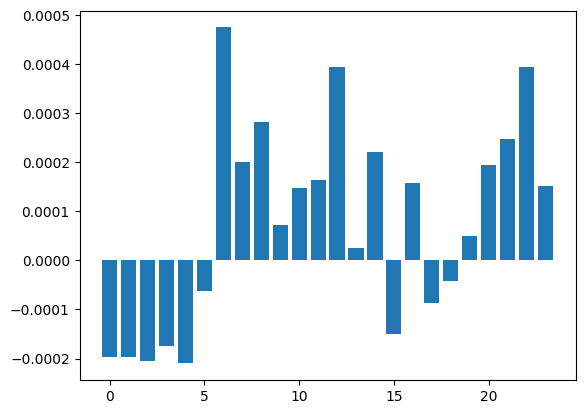

In [63]:
df_hour["Hour"] = df_hour["Open time"].dt.hour
tmp = df_hour.groupby("Hour")["pct"].mean()
plt.bar(x=tmp.index, height=tmp)

In [64]:
# Calendar Effects:
df_hour["Is_AfterHour"] = df_hour["Open time"].dt.hour >= 22
df_hour["Is_Monday"] = df_hour["Open time"].dt.day_of_week == 0
dt_indicators.extend([f'Is_AfterHour', f'Is_Monday'])

In [65]:
#berechnet performance für das gewollte Zeitfenster
def create_labels(df: pd.DataFrame, window: int):
    data = df.copy()
    data["future_return"] = data["Close"].shift(-window) / data["Close"] - 1
    data["label"] = (data["future_return"] > TRANSACTION_COSTS*2).astype(int)
    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

In [118]:
from sklearn import tree
def train_model(data: pd.DataFrame, features: list, target: str, param_grid, estimator):
    # Indizes zurücksetzen, um Probleme mit der Indizierung zu vermeiden
    data = data.reset_index(drop=True)
    
    # Aufteilen der Daten in Trainings- und Testdaten
    train_size = int(len(data) * 0.8)
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]
    X_train = train_data[features].dropna()
    X_test = test_data[features]
    y_train = train_data[target]
    
    # Definiere den Precision-Scorer
    precision_scorer = make_scorer(precision_score, pos_label=1)
    
    # Initialisiere den GridSearchCV
    grid_search = GridSearchCV(estimator=estimator,
                               param_grid=param_grid,
                                cv=4,  # Anzahl der Cross-Validation-Folds
                                scoring=precision_scorer,  # Bewertungskriterium
                                n_jobs=-1,  # Nutze alle verfügbaren CPU-Kerne
                                verbose=2)  # Ausgabe von Fortschrittsinformationen

     # Führe GridSearch aus
    grid_search.fit(X_train, y_train)
    
    # Ausgabe der besten Parameter
    print("Beste Parameter:", grid_search.best_params_)
    
    # Modell mit den besten Parametern
    best_clf = grid_search.best_estimator_
    return best_clf, X_test, X_train
    
def make_signals(pred: pd.Series, holding_period: int):
    np_pred = pred
    for i in reversed(range(len(np_pred))):
        if np_pred[i] == 1:
            np_pred[i:i+holding_period] = 1
    np_pred = np_pred
    return np_pred 
    
def evaluate_model(X_test, best_clf, data, signal_threshold, holding_period, plot=True):
    # Vorhersagen auf Testdaten
    #y_pred = best_clf.predict(X_test)
    
    #best_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
    #best_clf.fit(X_train, y_train)
    
    # TODO print out sharpe ratio in training data set
    # y_pred_proba = best_clf.predict_proba(X_train)
    # y_pred = (y_pred_proba[:, 1] > signal_threshold).astype(int)
    # y_pred = make_signals(y_pred, holding_period)
    # print(f"Sharpe Strategy (Train): {sharpe}")

    # Get the predicted probabilities
    y_pred_proba = best_clf.predict_proba(X_test)
    y_pred = (y_pred_proba[:, 1] > signal_threshold).astype(int)
    y_pred = make_signals(y_pred, holding_period)
    
    # Berechne die Sharpe Ratio
    test_returns = data.loc[X_test.index, "pct"]
    print(f'Sharpe BTC {sharpe_ratio(test_returns)}')

    strat_returns = test_returns.copy()
    strat_returns[y_pred == 0] = 0

    # Calculate transaction costs: a cost occurs whenever there is a change in the position (buy/sell)
    positions = np.diff(np.concatenate([[0], y_pred]))  # Calculate position changes
    transaction_costs = np.abs(positions) * TRANSACTION_COSTS  # Apply transaction costs

    sharpe = sharpe_ratio(strat_returns)
    print(f"Sharpe Ratio without costs: {sharpe}")
    strat_returns -= transaction_costs  # Deduct transaction costs from strategy returns

    print(f"number of transactions {np.sum(np.abs(positions))}")

    sharpe = sharpe_ratio(strat_returns)
    print(f"Sharpe Ratio with costs: {sharpe}")
    
    # Performance DataFrame erstellen
    if plot:
        # Performance DataFrame erstellen
        PF = pd.DataFrame(data["pct"].iloc[X_test.index])
        PF["pred"] = y_pred
        PF["strategy_returns"] = PF["pred"] * PF["pct"]
        PF["cumulative_strategy_returns"] = (PF["strategy_returns"] + 1).cumprod()

        PF["benchmark_returns"] = PF["pct"]
        PF["cumulative_benchmark_returns"] = (PF["benchmark_returns"] + 1).cumprod()

        # Calculate transaction indices
        transaction_indices = np.where(np.abs(positions) > 0)[0]

        # Adjust transaction_indices to match PF index
        transaction_indices = transaction_indices[transaction_indices < len(PF)]

        # Plot results
        plt.figure(figsize=(14, 7))
        plt.plot(PF["cumulative_strategy_returns"], label="Strategy Returns")
        plt.plot(PF["cumulative_benchmark_returns"], label="Benchmark Returns")

        # Add dots where transactions occur
        plt.scatter(PF.index[transaction_indices], 
                    PF["cumulative_strategy_returns"].iloc[transaction_indices],
                    color='red', 
                    marker='o', 
                    label='Transactions')

        plt.title("Cumulative Returns with Transactions")
        plt.xlabel("Time")
        plt.ylabel("Cumulative Returns")
        plt.legend()
        plt.show()
    
    return sharpe

In [67]:
def find_best_indicators(data: pd.DataFrame, indicators: list, target: str, holding_period, signal_threshold, plot=True):
    best_sharpe = -np.inf
    best_combination = None
    best_model = None

    # Definiere den Parameterbereich für GridSearch
    param_grid = {
        #'criterion': ['gini', 'entropy'],
        #'max_depth': [2, 3, 4],
        #'min_samples_split': [2, 5, 10],
        #'min_samples_leaf': [5, 10, 20, 30],
        #'max_features': ['sqrt']
    }

    models = []
    train_sharpe_ratios = []
    test_sharpe_ratios = []
    combos = []
    for r in [1, 2, len(indicators)]:
        for combo in combinations(indicators, r):
            if len(train_sharpe_ratios) > 100: 
                break
            print(combo)
            features = list(combo)
            clf, X_test, X_train = train_model(data, features, target, param_grid=param_grid, estimator=XGBClassifier(random_state=42))
            
            train_sharpe = evaluate_model(X_train, clf, signal_threshold=signal_threshold, holding_period=holding_period, data=data, plot=plot)
            test_sharpe = evaluate_model(X_test, clf, signal_threshold=signal_threshold, holding_period=holding_period, data=data, plot=plot)

            train_sharpe_ratios.append(train_sharpe)
            test_sharpe_ratios.append(test_sharpe)
            models.append(clf)
            combos.append(features)
            
            if test_sharpe > best_sharpe:
                best_sharpe = test_sharpe
                best_combination = combo
                best_model = clf

    print(f"Best Sharpe Ratio: {best_sharpe}")
    print(f"Best Indicator Combination: {best_combination}")

    return best_model, best_combination, best_sharpe, train_sharpe_ratios, test_sharpe_ratios, models, combos

# Finding optimal holding period

In [129]:
qs = []
windows = [1, 5, 12, 24, 32, 48, 96, 7*24]
for holding_window in windows:

    # Labels erstellen
    labeled_data = create_labels(df_hour, window=holding_window)

    #dt_indicators.extend([f'EMA_{5}', f'EMA_{50}', f'EMA_{500}'])
    # Liste der Indikatoren
    #["SMA_50_Sig", "SMA_500_Sig", "HMA_50_Sig", "EMA_50_Sig", "EMA_500_Sig", "EMA_5_Sig"]#["OBV", "RSI_5", "RSI_10"]#, "RSI_50", "RSI_50", "MACD", "MACD_Signal", "Momentum_10", "StochRSI_10", "StochRSI_20", "StochRSI_50"]
    features = dt_indicators

    # Beste Indikatoren finden
    best_model, best_combination, best_sharpe, train_sharpe_ratios, test_sharpe_ratios, models, combos = find_best_indicators(labeled_data, 
                                                                                                                            features, 
                                                                                                                            holding_period=holding_window, 
                                                                                                                            target="label", 
                                                                                                                            signal_threshold=0.55,
                                                                                                                            plot=False)
    res = pd.DataFrame.from_dict({"test":test_sharpe_ratios, 
                                "train":train_sharpe_ratios})
    q = res["test"].quantile(0.8)
    qs.append(q)

('OBV',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000014, std=0.001207
Sharpe Ratio without costs: 0.01118433327519824
number of transactions 160
mean=0.000011, std=0.001205
Sharpe Ratio with costs: 0.00907482933008401
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('MACD',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000011, std=0.001469
Sharpe Ratio without costs: 0.007785079239894403
number of transactions 34
mean=0.000011, std=0.001467
Sharpe Ratio with costs: 0.0074219043441330615
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000011, std=0.001122
Sharpe Ratio without costs: 0.009671147741038706
number of transactions 16
mean=0.000010, std=0.001119
Sharpe Ratio with costs: 0.008783686638006829
('RSI_24',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000006, std=0.000701
Sharpe Ratio without costs: 0.008623078053881812
number of transactions 233
mean=0.000002, std=0.000699
Sharpe Ratio with costs: 0.003306406505204526
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000009, std=0.000474
Sharpe Ratio without costs: 0.019626943498471196
number of transactions 56
mean=0.0000

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_24_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_24',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000026, std=0.001719
Sharpe Ratio without costs: 0.015117556260993174
number of transactions 472
mean=0.000018, std=0.001717
Sharpe Ratio with costs: 0.01073048672069117
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000007, std=0.001528
Sharpe Ratio without costs: 0.004744840595018681
number of transactions 192
mean=-0.000005, std=0.001532
Sharpe Ratio with costs: -0.003310590031034665
('StochRSI_24',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
(

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_168_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('EMA_168_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_168_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_168',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('StochRSI_168',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('RSI_720',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_720_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('EMA_720_Sig',)


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_720_Sig',)


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_720',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000010, std=0.000755
Sharpe Ratio without costs: 0.013433432117729006
number of transactions 86
mean=0.000009, std=0.000753
Sharpe Ratio with costs: 0.011635135353742112
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000003, std=0.000209
Sharpe Ratio without costs: 0.015180692918347753
number of transactions 4
mean=0.000003, std=0.000201
Sharpe Ratio with costs: 0.014464974284554073
('StochRSI_720',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Is

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Is_Monday',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'MACD')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000358, std=0.003222
Sharpe Ratio without costs: 0.11118029097973307
number of transactions 3070
mean=0.000309, std=0.003194
Sharpe Ratio with costs: 0.09677500144075993
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000036, std=0.001685
Sharpe Ratio without costs: 0.021520880811230346
number of transactions 346
mean=0.000014, std=0.001682
Sharpe Ratio with costs: 0.00837692195710684
('OBV', 'RSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000341, std=0.002931
Sharpe Ratio without costs: 0.11632835885388963
number of transactions 3432
mean=0.000286, std=0.002900
Sharpe Ratio with costs: 0.09866441087356294
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=-0.000001, std=0.001132
Sharpe Ratio without costs: -0.0009358033146276219
number of transactions 360
mea

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000033, std=0.001548
Sharpe Ratio without costs: 0.021199432692209374
number of transactions 664
mean=0.000022, std=0.001544
Sharpe Ratio with costs: 0.014365987328060575
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'HMA_24_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000030, std=0.001400
Sharpe Ratio without costs: 0.021575073266459657
number of transactions 630
mean=0.000020, std=0.001394
Sharpe Ratio with costs: 0.014428457819211444
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'Momentum_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000368, std=0.003448
Sharpe Ratio without costs: 0.10662579270313809
number of transactions 3718
mean=0.000308, std=0.003422
Sharpe Ratio with costs: 0.09006920112790429
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000005, std=0.001551
Sharpe Ratio without costs: 0.002956671722052962
number of transactions 240
mean=-0.000011, std=0.001556
Sharpe Ratio with costs: -0.0069481453590947645
('OBV', 'StochRSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000302, std=0.002689
Sharpe Ratio without costs: 0.11222658511624647
number of transactions 3738
mean=0.000242, std=0.002657
Sharpe Ratio with costs: 0.09104088782585446
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=-0.000005, std=0.000923
Sharpe Ratio without costs: -0.005848949626197723
number of transactions

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000031, std=0.001552
Sharpe Ratio without costs: 0.020073743197339497
number of transactions 512
mean=0.000023, std=0.001548
Sharpe Ratio with costs: 0.014829558002430111
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'HMA_168_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000028, std=0.001466
Sharpe Ratio without costs: 0.019008905482853927
number of transactions 368
mean=0.000022, std=0.001462
Sharpe Ratio with costs: 0.015031682070405061
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'Momentum_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000384, std=0.003149
Sharpe Ratio without costs: 0.12210655514064754
number of transactions 3270
mean=0.000332, std=0.003120
Sharpe Ratio with costs: 0.10647756875203067
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000035, std=0.002076
Sharpe Ratio without costs: 0.016919963491225615
number of transactions 406
mean=0.000009, std=0.002078
Sharpe Ratio with costs: 0.0043728115489105315
('OBV', 'StochRSI_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000300, std=0.002695
Sharpe Ratio without costs: 0.11145669672764344
number of transactions 3276
mean=0.000248, std=0.002664
Sharpe Ratio with costs: 0.09308382409383215
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=-0.000000, std=0.001128
Sharpe Ratio without costs: -0.00010757727113942946
number of transaction

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000025, std=0.001128
Sharpe Ratio without costs: 0.02256487678602538
number of transactions 434
mean=0.000018, std=0.001124
Sharpe Ratio with costs: 0.016464793614136507
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000007, std=0.000353
Sharpe Ratio without costs: 0.02018438122569395
number of transactions 40
mean=0.000005, std=0.000353
Sharpe Ratio with costs: 0.012909020767230288
('OBV', 'HMA_720_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000040, std=0.001455
Sharpe Ratio without costs: 0.02764166228122093
number of transactions 732
mean=0.000028, std=0.001450
Sharpe Ratio with costs: 0.019639368919447318
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000315, std=0.002975
Sharpe Ratio without costs: 0.10604725433755459
number of transactions 2866
mean=0.000270, std=0.002952
Sharpe Ratio with costs: 0.09132076888257079
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=-0.000002, std=0.001064
Sharpe Ratio without costs: -0.0019550387119563074
number of transactions 260
mean=-0.000019, std=0.001070
Sharpe Ratio with costs: -0.017538954342494157
('OBV', 'StochRSI_720')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000329, std=0.002655
Sharpe Ratio without costs: 0.12396778255256052
number of transactions 3355
mean=0.000275, std=0.002621
Sharpe Ratio with costs: 0.10508271599573529
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000018, std=0.001249
Sharpe Ratio without costs: 0.014667331316778711
number of transaction

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000050, std=0.001961
Sharpe Ratio without costs: 0.0256432273617072
number of transactions 906
mean=0.000036, std=0.001954
Sharpe Ratio with costs: 0.018304972692274102
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000001, std=0.001645
Sharpe Ratio without costs: 0.000785829697214182
number of transactions 352
mean=-0.000021, std=0.001652
Sharpe Ratio with costs: -0.012886199878977373
('SMA_24_Sig', 'StochRSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000027, std=0.000803
Sharpe Ratio without costs: 0.033103840155823835
number of transactions 624
mean=0.000017, std=0.000792
Sharpe Ratio with costs: 0.02095218522477945
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000005, std=0.000707
Sharpe Ratio without costs: 0.006407391453164868
number of transacti

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'HMA_168_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000023, std=0.001213
Sharpe Ratio without costs: 0.019341723420436125
number of transactions 810
mean=0.000010, std=0.001207
Sharpe Ratio with costs: 0.008685813188606043
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=-0.000017, std=0.001389
Sharpe Ratio without costs: -0.011912386688278764
number of transactions 300
mean=-0.000036, std=0.001398
Sharpe Ratio with costs: -0.02561586483607287
('SMA_24_Sig', 'StochRSI_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000007, std=0.000405
Sharpe Ratio without costs: 0.01653636351776845
number of transactions 266
mean=0.000002, std=0.000399
Sharpe Ratio with costs: 0.00607969761315552
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000004, std=0.000312
Sharpe Ratio without costs: 0.011204639878439497
number of transa

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'HMA_720_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_720')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000051, std=0.001668
Sharpe Ratio without costs: 0.030538882502696107
number of transactions 1006
mean=0.000035, std=0.001663
Sharpe Ratio with costs: 0.02095006097454635
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000005, std=0.001064
Sharpe Ratio without costs: 0.004415059652569078
number of transactions 326
mean=-0.000016, std=0.001072
Sharpe Ratio with costs: -0.015132762865200357
('SMA_24_Sig', 'StochRSI_720')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000020, std=0.000808
Sharpe Ratio without costs: 0.025207412790398228
number of transactions 782
mean=0.000008, std=0.000802
Sharpe Ratio with costs: 0.009757235763803135
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000003, std=0.000660
Sharpe Ratio without costs: 0.004785060974476615
number of trans

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('EMA_24_Sig', 'HMA_24_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.0048982231606265235
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005481
Sharpe BTC 0.017972767781972186
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Best Sharpe Ratio: 0.02319677193691399
Best Indicator Combination: ('MACD', 'Is_AfterHour')
('OBV',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000113, std=0.003851
Sharpe Ratio without costs: 0.029233430388169637
number of transactions 938
mean=0.000098, std=0.003851
Sharpe Ratio with costs: 0.02533074620168649
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000002, std=0.000436
Sharpe Ratio without costs: 0.003956555013058237
number of transactions 14
mean=0.000001, std=0.000436
Sharpe Ratio with costs: 0.0018938878842590676
('MACD',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000067, std=0.004112
Sharpe Ratio without costs: 0.016229849870334663
number of transactions 1700
mean=0.000039, std=0.004114
Sharpe Ratio with costs: 0.009597225489015378
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000005, std=0.003106
Sharpe Ratio without costs: 0.0015825181740109625
number of transactions 444
mean=-0.0000

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_24_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_24',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000067, std=0.004530
Sharpe Ratio without costs: 0.014683749842887322
number of transactions 1660
mean=0.000040, std=0.004532
Sharpe Ratio with costs: 0.008800119548497576
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000058, std=0.003207
Sharpe Ratio without costs: 0.018219204591029756
number of transactions 432
mean=0.000031, std=0.003209
Sharpe Ratio with costs: 0.009575293594600092
('StochRSI_24',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000038, std=0.002568
Sharpe Ratio without costs: 0.014935880090263413
number of transactions 1302
mean=0.000017, std=0.002571
Sharpe Ratio with costs: 0.006794711393498609
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000004, std=0.001815
Sharpe Ratio without costs: 0.0024598847753952687
number of transactions 332
mea

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_168_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_168',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000065, std=0.003147
Sharpe Ratio without costs: 0.020499596283428626
number of transactions 1136
mean=0.000046, std=0.003148
Sharpe Ratio with costs: 0.014705287471933799
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000032, std=0.002215
Sharpe Ratio without costs: 0.01422476499197742
number of transactions 384
mean=0.000007, std=0.002219
Sharpe Ratio with costs: 0.0030941163614164177
('StochRSI_168',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000042, std=0.002522
Sharpe Ratio without costs: 0.016530071881731
number of transactions 1072
mean=0.000025, std=0.002522
Sharpe Ratio with costs: 0.009714884932404782
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=-0.000011, std=0.001611
Sharpe Ratio without costs: -0.006552135413454584
number of transactions 278
mean

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_720_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_720',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000051, std=0.002845
Sharpe Ratio without costs: 0.018040915848042995
number of transactions 842
mean=0.000038, std=0.002846
Sharpe Ratio with costs: 0.01329269563520836
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000028, std=0.002323
Sharpe Ratio without costs: 0.012068039685770861
number of transactions 340
mean=0.000006, std=0.002327
Sharpe Ratio with costs: 0.0026733318295074937
('StochRSI_720',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000053, std=0.002764
Sharpe Ratio without costs: 0.01902827251327343
number of transactions 1339
mean=0.000031, std=0.002767
Sharpe Ratio with costs: 0.011249434008916473
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000004, std=0.001950
Sharpe Ratio without costs: 0.0022280006309979327
number of transactions 326
mean

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'MACD')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000487, std=0.005672
Sharpe Ratio without costs: 0.08585726656080793
number of transactions 2480
mean=0.000447, std=0.005676
Sharpe Ratio with costs: 0.07879553446301557
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=-0.000002, std=0.003668
Sharpe Ratio without costs: -0.0006106482196604177
number of transactions 376
mean=-0.000026, std=0.003669
Sharpe Ratio with costs: -0.007185596269814925
('OBV', 'RSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000441, std=0.005822
Sharpe Ratio without costs: 0.0757652398010396
number of transactions 2792
mean=0.000396, std=0.005826
Sharpe Ratio with costs: 0.06803288756022292
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000034, std=0.003193
Sharpe Ratio without costs: 0.010578279567296825
number of transactions 494
mea

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000089, std=0.004929
Sharpe Ratio without costs: 0.01815323790420746
number of transactions 2236
mean=0.000054, std=0.004931
Sharpe Ratio with costs: 0.010871492233630035
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000068, std=0.003478
Sharpe Ratio without costs: 0.019549215197665247
number of transactions 568
mean=0.000032, std=0.003480
Sharpe Ratio with costs: 0.009069165331479959
('SMA_24_Sig', 'StochRSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000119, std=0.003956
Sharpe Ratio without costs: 0.030188766769406322
number of transactions 2522
mean=0.000079, std=0.003960
Sharpe Ratio with costs: 0.019947350808667573
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000024, std=0.002718
Sharpe Ratio without costs: 0.008873297422101044
number of transacti

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'HMA_168_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000111, std=0.004113
Sharpe Ratio without costs: 0.027015662312105414
number of transactions 2140
mean=0.000077, std=0.004115
Sharpe Ratio with costs: 0.01866492443087093
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000031, std=0.003252
Sharpe Ratio without costs: 0.009658208020269444
number of transactions 586
mean=-0.000006, std=0.003257
Sharpe Ratio with costs: -0.0019014858975058332
('SMA_24_Sig', 'StochRSI_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000097, std=0.004415
Sharpe Ratio without costs: 0.02202472296768491
number of transactions 2796
mean=0.000052, std=0.004417
Sharpe Ratio with costs: 0.011863542460761314
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=-0.000022, std=0.003100
Sharpe Ratio without costs: -0.006959724845849645
number of tran

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'HMA_720_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_720')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000138, std=0.004451
Sharpe Ratio without costs: 0.03105470632169462
number of transactions 2140
mean=0.000104, std=0.004453
Sharpe Ratio with costs: 0.023338374546740086
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000055, std=0.003172
Sharpe Ratio without costs: 0.01743030577114982
number of transactions 600
mean=0.000017, std=0.003174
Sharpe Ratio with costs: 0.005290726483501481
('SMA_24_Sig', 'StochRSI_720')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000115, std=0.004387
Sharpe Ratio without costs: 0.02619187450684186
number of transactions 2553
mean=0.000074, std=0.004389
Sharpe Ratio with costs: 0.016850375046762674
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=-0.000031, std=0.003219
Sharpe Ratio without costs: -0.009680827729100205
number of transact

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('EMA_24_Sig', 'HMA_24_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007515
Sharpe BTC 0.004927203399749705
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018591129683911748
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Best Sharpe Ratio: 0.02039335012534137
Best Indicator Combination: ('OBV', 'RSI_720')
('OBV',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000122, std=0.005949
Sharpe Ratio without costs: 0.020511914978042507
number of transactions 712
mean=0.000111, std=0.005950
Sharpe Ratio with costs: 0.018590237027518726
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000010, std=0.002377
Sharpe Ratio without costs: 0.004182294220628719
number of transactions 56
mean=0.000006, std=0.002377
Sharpe Ratio with costs: 0.0026714791655610024
('MACD',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000049, std=0.005003
Sharpe Ratio without costs: 0.009772322342171897
number of transactions 1014
mean=0.000033, std=0.005003
Sharpe Ratio with costs: 0.006522834849490803
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000056, std=0.003638
Sharpe Ratio without costs: 0.015492553919570147
number of transactions 288
mean=0.00003

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_24_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_24',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000063, std=0.005705
Sharpe Ratio without costs: 0.011007606412460244
number of transactions 1231
mean=0.000043, std=0.005706
Sharpe Ratio with costs: 0.00754465877216341
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000053, std=0.004092
Sharpe Ratio without costs: 0.012832351566959723
number of transactions 278
mean=0.000035, std=0.004093
Sharpe Ratio with costs: 0.008474070435559696
('StochRSI_24',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000110, std=0.004660
Sharpe Ratio without costs: 0.023580644587411315
number of transactions 1618
mean=0.000084, std=0.004661
Sharpe Ratio with costs: 0.01800588538054314
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000056, std=0.003409
Sharpe Ratio without costs: 0.016488380177207766
number of transactions 390
mean=0

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_168_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_168',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000091, std=0.005622
Sharpe Ratio without costs: 0.0161680165804587
number of transactions 1328
mean=0.000070, std=0.005624
Sharpe Ratio with costs: 0.012375555064380648
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000075, std=0.004336
Sharpe Ratio without costs: 0.017238963532475993
number of transactions 311
mean=0.000055, std=0.004338
Sharpe Ratio with costs: 0.012628674694462896
('StochRSI_168',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000076, std=0.004886
Sharpe Ratio without costs: 0.015605116709997934
number of transactions 1290
mean=0.000056, std=0.004888
Sharpe Ratio with costs: 0.011363759691213124
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000009, std=0.003819
Sharpe Ratio without costs: 0.002278462106136218
number of transactions 296
mean=

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_720_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_720',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000131, std=0.005231
Sharpe Ratio without costs: 0.025103018506440675
number of transactions 884
mean=0.000117, std=0.005232
Sharpe Ratio with costs: 0.02238736728155394
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000072, std=0.004213
Sharpe Ratio without costs: 0.0171198241990315
number of transactions 235
mean=0.000057, std=0.004213
Sharpe Ratio with costs: 0.013541934359483263
('StochRSI_720',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000106, std=0.004785
Sharpe Ratio without costs: 0.022148547683033416
number of transactions 1290
mean=0.000085, std=0.004787
Sharpe Ratio with costs: 0.017816813650378037
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000086, std=0.003756
Sharpe Ratio without costs: 0.0228013274645687
number of transactions 338
mean=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'MACD')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000297, std=0.006766
Sharpe Ratio without costs: 0.04388731135737862
number of transactions 1064
mean=0.000280, std=0.006768
Sharpe Ratio with costs: 0.04135148404357068
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000039, std=0.004097
Sharpe Ratio without costs: 0.009459877083043312
number of transactions 248
mean=0.000023, std=0.004097
Sharpe Ratio with costs: 0.005576899085991292
('OBV', 'RSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000269, std=0.006727
Sharpe Ratio without costs: 0.03999127092194071
number of transactions 1046
mean=0.000252, std=0.006729
Sharpe Ratio with costs: 0.037486515088467315
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000066, std=0.004045
Sharpe Ratio without costs: 0.016293317503479076
number of transactions 262
mean=0

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000053, std=0.006197
Sharpe Ratio without costs: 0.008629214423122757
number of transactions 1328
mean=0.000032, std=0.006198
Sharpe Ratio with costs: 0.005190726554148405
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000019, std=0.004444
Sharpe Ratio without costs: 0.004328332930878454
number of transactions 302
mean=-0.000000, std=0.004445
Sharpe Ratio with costs: -3.2143501748896975e-05
('SMA_24_Sig', 'StochRSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000103, std=0.006049
Sharpe Ratio without costs: 0.01710727468248724
number of transactions 1761
mean=0.000075, std=0.006052
Sharpe Ratio with costs: 0.01242991444857209
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000044, std=0.004547
Sharpe Ratio without costs: 0.009663201150712938
number of transa

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'HMA_168_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000107, std=0.006411
Sharpe Ratio without costs: 0.016765059778444412
number of transactions 1360
mean=0.000086, std=0.006413
Sharpe Ratio with costs: 0.013357648725714613
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000117, std=0.004755
Sharpe Ratio without costs: 0.02452905376048937
number of transactions 267
mean=0.000100, std=0.004758
Sharpe Ratio with costs: 0.020914703151810935
('SMA_24_Sig', 'StochRSI_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000084, std=0.006313
Sharpe Ratio without costs: 0.01324826040863709
number of transactions 1467
mean=0.000060, std=0.006314
Sharpe Ratio with costs: 0.009518542839328932
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000082, std=0.004471
Sharpe Ratio without costs: 0.018293423009218653
number of transacti

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'HMA_720_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_720')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000137, std=0.006115
Sharpe Ratio without costs: 0.02245118686797533
number of transactions 1064
mean=0.000120, std=0.006115
Sharpe Ratio with costs: 0.019657566572224026
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000063, std=0.004476
Sharpe Ratio without costs: 0.014040985502702184
number of transactions 227
mean=0.000048, std=0.004478
Sharpe Ratio with costs: 0.010781484017600842
('SMA_24_Sig', 'StochRSI_720')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000109, std=0.006585
Sharpe Ratio without costs: 0.016562782085788704
number of transactions 1333
mean=0.000088, std=0.006586
Sharpe Ratio with costs: 0.013315061550051575
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000058, std=0.004731
Sharpe Ratio without costs: 0.01233187156279916
number of transacti

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('EMA_24_Sig', 'HMA_24_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007516
Sharpe BTC 0.004914034224969797
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000102, std=0.005473
Sharpe BTC 0.018606513206794257
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Best Sharpe Ratio: 0.02629029030144898
Best Indicator Combination: ('RSI_24', 'HMA_168_Sig')
('OBV',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000112, std=0.006964
Sharpe Ratio without costs: 0.01607222835285709
number of transactions 332
mean=0.000107, std=0.006964
Sharpe Ratio with costs: 0.01530649367476988
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000023, std=0.002610
Sharpe Ratio without costs: 0.008631952397271016
number of transactions 44
mean=0.000020, std=0.002610
Sharpe Ratio with costs: 0.007549753946861723
('MACD',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000049, std=0.006709
Sharpe Ratio without costs: 0.007329560367370886
number of transactions 621
mean=0.000039, std=0.006709
Sharpe Ratio with costs: 0.005844221439145148
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000074, std=0.004779
Sharpe Ratio without costs: 0.015395727146752277
number of transactions 153
mean=0.000064, std

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_24_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_24',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000038, std=0.007147
Sharpe Ratio without costs: 0.005386851733729141
number of transactions 523
mean=0.000030, std=0.007147
Sharpe Ratio with costs: 0.004212892480298458
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000066, std=0.005150
Sharpe Ratio without costs: 0.012891958892272076
number of transactions 129
mean=0.000058, std=0.005151
Sharpe Ratio with costs: 0.011282399593215453
('StochRSI_24',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000073, std=0.007059
Sharpe Ratio without costs: 0.010270881055549342
number of transactions 630
mean=0.000062, std=0.007060
Sharpe Ratio with costs: 0.008837734598105542
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000101, std=0.005195
Sharpe Ratio without costs: 0.019412671142576988
number of transactions 150
mean=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_168_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_168',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000051, std=0.007013
Sharpe Ratio without costs: 0.007325506940531805
number of transactions 506
mean=0.000043, std=0.007014
Sharpe Ratio with costs: 0.006166766570782287
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000123, std=0.005059
Sharpe Ratio without costs: 0.024360228643457847
number of transactions 99
mean=0.000117, std=0.005059
Sharpe Ratio with costs: 0.02310161863323416
('StochRSI_168',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000055, std=0.007194
Sharpe Ratio without costs: 0.0076380447928682624
number of transactions 485
mean=0.000047, std=0.007195
Sharpe Ratio with costs: 0.00655542497898686
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000073, std=0.005246
Sharpe Ratio without costs: 0.013822601149495635
number of transactions 101
mean=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_720_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_720',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000088, std=0.006937
Sharpe Ratio without costs: 0.012655403508108369
number of transactions 409
mean=0.000081, std=0.006937
Sharpe Ratio with costs: 0.011708882808558875
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000080, std=0.005026
Sharpe Ratio without costs: 0.015922708026710444
number of transactions 67
mean=0.000076, std=0.005026
Sharpe Ratio with costs: 0.015064759229851742
('StochRSI_720',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000076, std=0.006665
Sharpe Ratio without costs: 0.011354498432795766
number of transactions 517
mean=0.000067, std=0.006666
Sharpe Ratio with costs: 0.010107574435008692
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000095, std=0.004990
Sharpe Ratio without costs: 0.018958399200375262
number of transactions 152
mean=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'MACD')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000151, std=0.007219
Sharpe Ratio without costs: 0.02095033716640254
number of transactions 388
mean=0.000145, std=0.007219
Sharpe Ratio with costs: 0.02008626400119572
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000039, std=0.004535
Sharpe Ratio without costs: 0.008684949939798695
number of transactions 145
mean=0.000030, std=0.004535
Sharpe Ratio with costs: 0.0066327032014970744
('OBV', 'RSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000134, std=0.007275
Sharpe Ratio without costs: 0.018362893814981383
number of transactions 353
mean=0.000128, std=0.007275
Sharpe Ratio with costs: 0.017583567135777103
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000015, std=0.004712
Sharpe Ratio without costs: 0.003278013440153615
number of transactions 159
mean=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000043, std=0.006986
Sharpe Ratio without costs: 0.006216320956392612
number of transactions 529
mean=0.000035, std=0.006986
Sharpe Ratio with costs: 0.0050011501110216496
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000076, std=0.005107
Sharpe Ratio without costs: 0.014835638920857935
number of transactions 141
mean=0.000067, std=0.005106
Sharpe Ratio with costs: 0.013065964133252866
('SMA_24_Sig', 'StochRSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000056, std=0.007194
Sharpe Ratio without costs: 0.007789757226436544
number of transactions 495
mean=0.000048, std=0.007195
Sharpe Ratio with costs: 0.00668541446872207
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000092, std=0.005196
Sharpe Ratio without costs: 0.017672499636720004
number of transactions

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'HMA_168_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000063, std=0.007363
Sharpe Ratio without costs: 0.008565178256019731
number of transactions 325
mean=0.000058, std=0.007363
Sharpe Ratio with costs: 0.00785690169725764
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000113, std=0.005379
Sharpe Ratio without costs: 0.021003393913316994
number of transactions 59
mean=0.000109, std=0.005380
Sharpe Ratio with costs: 0.020298742581732438
('SMA_24_Sig', 'StochRSI_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000059, std=0.007269
Sharpe Ratio without costs: 0.008184434183701761
number of transactions 417
mean=0.000053, std=0.007269
Sharpe Ratio with costs: 0.007264209158373816
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000089, std=0.005304
Sharpe Ratio without costs: 0.01669861816835363
number of transactions 1

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'HMA_720_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_720')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000101, std=0.007250
Sharpe Ratio without costs: 0.01388894937159432
number of transactions 359
mean=0.000095, std=0.007251
Sharpe Ratio with costs: 0.013093390289713161
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000085, std=0.005069
Sharpe Ratio without costs: 0.016749150001332754
number of transactions 49
mean=0.000082, std=0.005069
Sharpe Ratio with costs: 0.01612786917786297
('SMA_24_Sig', 'StochRSI_720')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000069, std=0.007267
Sharpe Ratio without costs: 0.00946854758246116
number of transactions 453
mean=0.000062, std=0.007268
Sharpe Ratio with costs: 0.008467933268963918
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000108, std=0.005208
Sharpe Ratio without costs: 0.020675216954305752
number of transactions 13

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('EMA_24_Sig', 'HMA_24_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007517
Sharpe BTC 0.004913383497813139
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005471
Sharpe BTC 0.01882355179843181
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Best Sharpe Ratio: 0.02310161863323416
Best Indicator Combination: ('Momentum_168',)
('OBV',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000083, std=0.007064
Sharpe Ratio without costs: 0.011714271690839663
number of transactions 219
mean=0.000079, std=0.007064
Sharpe Ratio with costs: 0.01121600754769416
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000025, std=0.002559
Sharpe Ratio without costs: 0.00976340394836372
number of transactions 38
mean=0.000023, std=0.002559
Sharpe Ratio with costs: 0.008811086782456722
('MACD',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000042, std=0.007459
Sharpe Ratio without costs: 0.005587243063838595
number of transactions 177
mean=0.000039, std=0.007459
Sharpe Ratio with costs: 0.005206304449444859
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000099, std=0.005431
Sharpe Ratio without costs: 0.018181656424642853
number of transactions 31
mean=0.000097, std=

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_24_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_24',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000045, std=0.007362
Sharpe Ratio without costs: 0.006091470290265603
number of transactions 247
mean=0.000041, std=0.007362
Sharpe Ratio with costs: 0.005552414194764998
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000098, std=0.005363
Sharpe Ratio without costs: 0.018291392603411775
number of transactions 75
mean=0.000093, std=0.005363
Sharpe Ratio with costs: 0.017393920641811812
('StochRSI_24',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000051, std=0.007440
Sharpe Ratio without costs: 0.006913485982817024
number of transactions 199
mean=0.000048, std=0.007441
Sharpe Ratio with costs: 0.006483180679651459
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000095, std=0.005370
Sharpe Ratio without costs: 0.017672848494064003
number of transactions 55
mean=0.000

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_168_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_168',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000044, std=0.007269
Sharpe Ratio without costs: 0.006038039349842954
number of transactions 211
mean=0.000041, std=0.007269
Sharpe Ratio with costs: 0.005572121997585679
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000087, std=0.005361
Sharpe Ratio without costs: 0.01625166352448675
number of transactions 41
mean=0.000084, std=0.005361
Sharpe Ratio with costs: 0.015758963679514612
('StochRSI_168',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000063, std=0.007266
Sharpe Ratio without costs: 0.008660503919811473
number of transactions 313
mean=0.000058, std=0.007266
Sharpe Ratio with costs: 0.007969244585542282
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000084, std=0.005283
Sharpe Ratio without costs: 0.01585521106483951
number of transactions 77
mean=0.0000

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_720_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_720',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000074, std=0.007038
Sharpe Ratio without costs: 0.01057526149290286
number of transactions 273
mean=0.000070, std=0.007039
Sharpe Ratio with costs: 0.00995163707337718
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000061, std=0.005027
Sharpe Ratio without costs: 0.012180309980440757
number of transactions 45
mean=0.000058, std=0.005026
Sharpe Ratio with costs: 0.011606586979843318
('StochRSI_720',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000047, std=0.007213
Sharpe Ratio without costs: 0.006497012415808857
number of transactions 261
mean=0.000043, std=0.007213
Sharpe Ratio with costs: 0.0059154394690171105
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000113, std=0.005262
Sharpe Ratio without costs: 0.021556481052542157
number of transactions 73
mean=0.000

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'MACD')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000116, std=0.007279
Sharpe Ratio without costs: 0.01598380234356529
number of transactions 267
mean=0.000112, std=0.007280
Sharpe Ratio with costs: 0.015393644422481525
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000074, std=0.004914
Sharpe Ratio without costs: 0.015030282666428467
number of transactions 115
mean=0.000066, std=0.004915
Sharpe Ratio with costs: 0.013525891952215839
('OBV', 'RSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000097, std=0.007377
Sharpe Ratio without costs: 0.013142610162493407
number of transactions 177
mean=0.000094, std=0.007377
Sharpe Ratio with costs: 0.012756036952810055
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000074, std=0.004931
Sharpe Ratio without costs: 0.015049143056816946
number of transactions 143
mean=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000030, std=0.007355
Sharpe Ratio without costs: 0.004078818726143475
number of transactions 231
mean=0.000026, std=0.007355
Sharpe Ratio with costs: 0.0035741444869138903
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000096, std=0.005341
Sharpe Ratio without costs: 0.01788766373182524
number of transactions 77
mean=0.000091, std=0.005342
Sharpe Ratio with costs: 0.0169603083582048
('SMA_24_Sig', 'StochRSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000035, std=0.007431
Sharpe Ratio without costs: 0.004704970106353059
number of transactions 111
mean=0.000033, std=0.007431
Sharpe Ratio with costs: 0.004465289064293513
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000104, std=0.005408
Sharpe Ratio without costs: 0.019282204698374005
number of transactions 53

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'HMA_168_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000055, std=0.007416
Sharpe Ratio without costs: 0.0073666027397583335
number of transactions 131
mean=0.000053, std=0.007415
Sharpe Ratio with costs: 0.007083329728349481
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000101, std=0.005429
Sharpe Ratio without costs: 0.018533065585690643
number of transactions 21
mean=0.000099, std=0.005429
Sharpe Ratio with costs: 0.018286042217033338
('SMA_24_Sig', 'StochRSI_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000042, std=0.007471
Sharpe Ratio without costs: 0.005667099299921489
number of transactions 103
mean=0.000041, std=0.007471
Sharpe Ratio with costs: 0.0054455025139033865
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000094, std=0.005437
Sharpe Ratio without costs: 0.01735273413561376
number of transaction

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000043, std=0.004817
Sharpe Ratio without costs: 0.008955953311682826
number of transactions 207
mean=0.000040, std=0.004817
Sharpe Ratio with costs: 0.008266724912715693
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000106, std=0.004350
Sharpe Ratio without costs: 0.02428878082431103
number of transactions 56
mean=0.000102, std=0.004349
Sharpe Ratio with costs: 0.02346874462398185
('SMA_24_Sig', 'HMA_720_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: 

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000080, std=0.007348
Sharpe Ratio without costs: 0.010917801472101077
number of transactions 221
mean=0.000077, std=0.007348
Sharpe Ratio with costs: 0.010434550778226049
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000086, std=0.005109
Sharpe Ratio without costs: 0.016915843301919815
number of transactions 25
mean=0.000085, std=0.005109
Sharpe Ratio with costs: 0.01660092879825391
('SMA_24_Sig', 'StochRSI_720')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000050, std=0.007467
Sharpe Ratio without costs: 0.006697838452308446
number of transactions 113
mean=0.000048, std=0.007467
Sharpe Ratio with costs: 0.006454582700825345
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000107, std=0.005413
Sharpe Ratio without costs: 0.01975062690454908
number of transactions 5

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000031, std=0.003892
Sharpe Ratio without costs: 0.00808584166018567
number of transactions 334
mean=0.000026, std=0.003893
Sharpe Ratio with costs: 0.006705125598482098
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=-0.000016, std=0.002979
Sharpe Ratio without costs: -0.005326155248141119
number of transactions 81
mean=-0.000021, std=0.002980
Sharpe Ratio with costs: -0.007069978038592649
('EMA_24_Sig', 'HMA_24_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007518
Sharpe BTC 0.004918108325860735
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000099, std=0.005463
Sharpe BTC 0.01806079156662666
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with cos

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000083, std=0.007046
Sharpe Ratio without costs: 0.011775360283206051
number of transactions 149
mean=0.000081, std=0.007046
Sharpe Ratio with costs: 0.011436252244854773
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000015, std=0.001665
Sharpe Ratio without costs: 0.008894355581252723
number of transactions 18
mean=0.000014, std=0.001666
Sharpe Ratio with costs: 0.008196211469581412
('MACD',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000037, std=0.007517
Sharpe Ratio without costs: 0.004984414334625511
number of transactions 11
mean=0.000037, std=0.007517
Sharpe Ratio with costs: 0.004960861024872009
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000100, std=0.005458
Sharpe Ratio without costs: 0.018234360753227635
number of transactions 5
mean=0.000099, st

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_24_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_24',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000035, std=0.007496
Sharpe Ratio without costs: 0.004667745175589949
number of transactions 15
mean=0.000035, std=0.007496
Sharpe Ratio with costs: 0.00463546698899162
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000092, std=0.005445
Sharpe Ratio without costs: 0.016808793283905304
number of transactions 7
mean=0.000091, std=0.005445
Sharpe Ratio with costs: 0.01672598972379893
('StochRSI_24',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000038, std=0.007519
Sharpe Ratio without costs: 0.005053485073124606
number of transactions 7
mean=0.000038, std=0.007519
Sharpe Ratio with costs: 0.0050384560897514885
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000098, std=0.005456
Sharpe Ratio without costs: 0.018036102393458032
number of transactions 3
mean=0.000098,

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_168_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_168',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000040, std=0.007448
Sharpe Ratio without costs: 0.005354933411699667
number of transactions 41
mean=0.000039, std=0.007448
Sharpe Ratio with costs: 0.005266502994343046
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000090, std=0.005407
Sharpe Ratio without costs: 0.01667469414888192
number of transactions 7
mean=0.000090, std=0.005407
Sharpe Ratio with costs: 0.016590270639251573
('StochRSI_168',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000044, std=0.007455
Sharpe Ratio without costs: 0.005865813107549049
number of transactions 45
mean=0.000043, std=0.007454
Sharpe Ratio with costs: 0.005769167881281705
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000104, std=0.005440
Sharpe Ratio without costs: 0.019063041864718428
number of transactions 17
mean=0.0001

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_720_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_720',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000064, std=0.007235
Sharpe Ratio without costs: 0.008840847877921354
number of transactions 143
mean=0.000062, std=0.007235
Sharpe Ratio with costs: 0.008523042443404145
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000086, std=0.005072
Sharpe Ratio without costs: 0.016874804640998196
number of transactions 17
mean=0.000084, std=0.005072
Sharpe Ratio with costs: 0.016659328942941566
('StochRSI_720',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000044, std=0.007493
Sharpe Ratio without costs: 0.0058087625835533604
number of transactions 55
mean=0.000043, std=0.007493
Sharpe Ratio with costs: 0.005690886247160614
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000103, std=0.005441
Sharpe Ratio without costs: 0.0190083583078889
number of transactions 11
mean=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'MACD')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000090, std=0.007375
Sharpe Ratio without costs: 0.012139403640757579
number of transactions 117
mean=0.000088, std=0.007375
Sharpe Ratio with costs: 0.011883949088499582
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000103, std=0.004631
Sharpe Ratio without costs: 0.02228258712302193
number of transactions 79
mean=0.000098, std=0.004632
Sharpe Ratio with costs: 0.021185370668991142
('OBV', 'RSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000074, std=0.007432
Sharpe Ratio without costs: 0.009964383268714664
number of transactions 91
mean=0.000073, std=0.007432
Sharpe Ratio with costs: 0.009767651779645664
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000053, std=0.004637
Sharpe Ratio without costs: 0.011345276185456842
number of transactions 69
mean=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000035, std=0.007514
Sharpe Ratio without costs: 0.004599008963174462
number of transactions 7
mean=0.000034, std=0.007514
Sharpe Ratio with costs: 0.004584008087170092
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000093, std=0.005446
Sharpe Ratio without costs: 0.017101512130012667
number of transactions 7
mean=0.000093, std=0.005446
Sharpe Ratio with costs: 0.017018850195351445
('SMA_24_Sig', 'StochRSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000037, std=0.007519
Sharpe Ratio without costs: 0.004941125533655121
number of transactions 1
mean=0.000037, std=0.007519
Sharpe Ratio with costs: 0.004938978684671815
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000100, std=0.005459
Sharpe Ratio without costs: 0.018261623825552586
number of transactions 1
m

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'HMA_168_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000035, std=0.007454
Sharpe Ratio without costs: 0.004754054726408596
number of transactions 25
mean=0.000035, std=0.007454
Sharpe Ratio with costs: 0.004699912798347964
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000099, std=0.005451
Sharpe Ratio without costs: 0.018213034530519832
number of transactions 3
mean=0.000099, std=0.005451
Sharpe Ratio with costs: 0.018177529968392715
('SMA_24_Sig', 'StochRSI_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000038, std=0.007514
Sharpe Ratio without costs: 0.00511533835729174
number of transactions 11
mean=0.000038, std=0.007514
Sharpe Ratio with costs: 0.005091852534887544
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000100, std=0.005459
Sharpe Ratio without costs: 0.01824760903184516
number of transactions 3


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'HMA_720_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_720')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000056, std=0.007356
Sharpe Ratio without costs: 0.0076711736971274164
number of transactions 79
mean=0.000055, std=0.007356
Sharpe Ratio with costs: 0.007498738152434496
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000097, std=0.005104
Sharpe Ratio without costs: 0.019025443171357688
number of transactions 13
mean=0.000096, std=0.005104
Sharpe Ratio with costs: 0.01886194238100896
('SMA_24_Sig', 'StochRSI_720')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000038, std=0.007515
Sharpe Ratio without costs: 0.005084556856903944
number of transactions 19
mean=0.000038, std=0.007515
Sharpe Ratio with costs: 0.005043990126438399
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000099, std=0.005455
Sharpe Ratio without costs: 0.018195123920963396
number of transactions

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000050, std=0.004570
Sharpe Ratio without costs: 0.010907729102223849
number of transactions 334
mean=0.000044, std=0.004571
Sharpe Ratio with costs: 0.009730972914651581
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000007, std=0.003409
Sharpe Ratio without costs: 0.0021916530321757295
number of transactions 81
mean=0.000002, std=0.003410
Sharpe Ratio with costs: 0.0006648308521168399
('EMA_24_Sig', 'HMA_24_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007519
Sharpe BTC 0.004914897358082494
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000100, std=0.005459
Sharpe BTC 0.018255332601360096
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with co

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000068, std=0.007331
Sharpe Ratio without costs: 0.009253266517121852
number of transactions 61
mean=0.000067, std=0.007332
Sharpe Ratio with costs: 0.009119355022904195
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000029, std=0.001941
Sharpe Ratio without costs: 0.014905720083492419
number of transactions 6
mean=0.000029, std=0.001940
Sharpe Ratio with costs: 0.014708050540311825
('MACD',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000037, std=0.007524
Sharpe Ratio without costs: 0.004949432051155629
number of transactions 1
mean=0.000037, std=0.007524
Sharpe Ratio with costs: 0.00494726559742792
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000103, std=0.005424
Sharpe Ratio without costs: 0.019075128789984856
number of transactions 1
mean=0.000103, std=0.

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_24_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_24',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000037, std=0.007524
Sharpe Ratio without costs: 0.004943423315450759
number of transactions 1
mean=0.000037, std=0.007524
Sharpe Ratio with costs: 0.004941291773796894
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000103, std=0.005424
Sharpe Ratio without costs: 0.01900789718529907
number of transactions 1
mean=0.000103, std=0.005424
Sharpe Ratio with costs: 0.018995927980840332
('StochRSI_24',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000037, std=0.007523
Sharpe Ratio without costs: 0.004949624501335336
number of transactions 1
mean=0.000037, std=0.007523
Sharpe Ratio with costs: 0.004947471749090453
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000103, std=0.005424
Sharpe Ratio without costs: 0.019061133627773348
number of transactions 1
mean=0.000103, 

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_168_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_168',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000038, std=0.007522
Sharpe Ratio without costs: 0.005048170441895244
number of transactions 5
mean=0.000038, std=0.007522
Sharpe Ratio with costs: 0.005037453808471916
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000106, std=0.005392
Sharpe Ratio without costs: 0.019591955810347776
number of transactions 3
mean=0.000105, std=0.005392
Sharpe Ratio with costs: 0.019554815691037612
('StochRSI_168',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000037, std=0.007524
Sharpe Ratio without costs: 0.004910133756216829
number of transactions 1
mean=0.000037, std=0.007524
Sharpe Ratio with costs: 0.004907968820616081
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000103, std=0.005424
Sharpe Ratio without costs: 0.019075128789984856
number of transactions 1
mean=0.000103

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_720_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_720',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000050, std=0.007429
Sharpe Ratio without costs: 0.0066716681701329385
number of transactions 39
mean=0.000049, std=0.007428
Sharpe Ratio with costs: 0.00658743303178823
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000095, std=0.005083
Sharpe Ratio without costs: 0.018640576601597375
number of transactions 3
mean=0.000095, std=0.005083
Sharpe Ratio with costs: 0.018601714560331405
('StochRSI_720',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000037, std=0.007522
Sharpe Ratio without costs: 0.004969303384649896
number of transactions 3
mean=0.000037, std=0.007522
Sharpe Ratio with costs: 0.004962894305330912
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000103, std=0.005424
Sharpe Ratio without costs: 0.019047155964548604
number of transactions 1
mean=0.00010

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'MACD')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000052, std=0.007487
Sharpe Ratio without costs: 0.006970682989302325
number of transactions 37
mean=0.000052, std=0.007487
Sharpe Ratio with costs: 0.0068912710082148065
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000091, std=0.004943
Sharpe Ratio without costs: 0.018344955059977113
number of transactions 35
mean=0.000088, std=0.004943
Sharpe Ratio with costs: 0.017890669003226174
('OBV', 'RSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000056, std=0.007477
Sharpe Ratio without costs: 0.007502940525697893
number of transactions 35
mean=0.000056, std=0.007477
Sharpe Ratio with costs: 0.00742766045916481
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000046, std=0.004296
Sharpe Ratio without costs: 0.01079530833747559
number of transactions 38
mean=0.000

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000037, std=0.007524
Sharpe Ratio without costs: 0.004943423315450759
number of transactions 1
mean=0.000037, std=0.007524
Sharpe Ratio with costs: 0.004941291773796894
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000103, std=0.005424
Sharpe Ratio without costs: 0.01900789718529907
number of transactions 1
mean=0.000103, std=0.005424
Sharpe Ratio with costs: 0.018995927980840332
('SMA_24_Sig', 'StochRSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000037, std=0.007523
Sharpe Ratio without costs: 0.004949624501335336
number of transactions 1
mean=0.000037, std=0.007523
Sharpe Ratio with costs: 0.004947471749090453
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000103, std=0.005424
Sharpe Ratio without costs: 0.019069313922924176
number of transactions 1
me

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'HMA_168_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000038, std=0.007522
Sharpe Ratio without costs: 0.005034359599622478
number of transactions 7
mean=0.000038, std=0.007522
Sharpe Ratio with costs: 0.005019311745493878
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000103, std=0.005424
Sharpe Ratio without costs: 0.019071574650831334
number of transactions 1
mean=0.000103, std=0.005424
Sharpe Ratio with costs: 0.019059759411689567
('SMA_24_Sig', 'StochRSI_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000037, std=0.007523
Sharpe Ratio without costs: 0.004966292878128585
number of transactions 1
mean=0.000037, std=0.007523
Sharpe Ratio with costs: 0.0049641660579592874
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000103, std=0.005424
Sharpe Ratio without costs: 0.019075128789984856
number of transactions 1

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'HMA_720_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_720')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000042, std=0.007500
Sharpe Ratio without costs: 0.005646952939046901
number of transactions 21
mean=0.000042, std=0.007500
Sharpe Ratio with costs: 0.005601825853402766
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000116, std=0.005261
Sharpe Ratio without costs: 0.022068064233151975
number of transactions 5
mean=0.000116, std=0.005261
Sharpe Ratio with costs: 0.022008968890171444
('SMA_24_Sig', 'StochRSI_720')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000037, std=0.007524
Sharpe Ratio without costs: 0.004943423315450759
number of transactions 1
mean=0.000037, std=0.007524
Sharpe Ratio with costs: 0.004941291773796894
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000103, std=0.005424
Sharpe Ratio without costs: 0.019075128789984856
number of transactions 1

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000040, std=0.006317
Sharpe Ratio without costs: 0.006276073443443163
number of transactions 333
mean=0.000034, std=0.006318
Sharpe Ratio with costs: 0.005427235124236316
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000015, std=0.004402
Sharpe Ratio without costs: 0.0033486860984864204
number of transactions 80
mean=0.000010, std=0.004403
Sharpe Ratio with costs: 0.0021793252755835445
('EMA_24_Sig', 'HMA_24_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007524
Sharpe BTC 0.004910133756216829
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000103, std=0.005424
Sharpe BTC 0.019075128789984856
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with co

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000063, std=0.007361
Sharpe Ratio without costs: 0.008518775363617446
number of transactions 29
mean=0.000062, std=0.007361
Sharpe Ratio with costs: 0.008455036551728847
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000041, std=0.001720
Sharpe Ratio without costs: 0.02383182090325871
number of transactions 4
mean=0.000041, std=0.001720
Sharpe Ratio with costs: 0.023682798975671406
('MACD',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000038, std=0.007529
Sharpe Ratio without costs: 0.005020841862332595
number of transactions 1
mean=0.000038, std=0.007529
Sharpe Ratio with costs: 0.005018730836184609
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000091, std=0.005390
Sharpe Ratio without costs: 0.016881670484030095
number of transactions 1
mean=0.000091, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_24_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_24',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000037, std=0.007529
Sharpe Ratio without costs: 0.004972783360102672
number of transactions 1
mean=0.000037, std=0.007529
Sharpe Ratio with costs: 0.004970632591908767
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000091, std=0.005390
Sharpe Ratio without costs: 0.01687721874031521
number of transactions 1
mean=0.000091, std=0.005390
Sharpe Ratio with costs: 0.01686524328280355
('StochRSI_24',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000038, std=0.007529
Sharpe Ratio without costs: 0.0049860463738786685
number of transactions 1
mean=0.000038, std=0.007529
Sharpe Ratio with costs: 0.004983891040501938
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000091, std=0.005390
Sharpe Ratio without costs: 0.01687721874031521
number of transactions 1
mean=0.000091, std

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_168_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_168',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000037, std=0.007529
Sharpe Ratio without costs: 0.004979836515792067
number of transactions 1
mean=0.000037, std=0.007529
Sharpe Ratio with costs: 0.004977702474057178
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000089, std=0.005388
Sharpe Ratio without costs: 0.016485800702525564
number of transactions 1
mean=0.000089, std=0.005388
Sharpe Ratio with costs: 0.01647355356023649
('StochRSI_168',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000037, std=0.007529
Sharpe Ratio without costs: 0.004946507140612812
number of transactions 1
mean=0.000037, std=0.007529
Sharpe Ratio with costs: 0.004944339576676107
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000091, std=0.005390
Sharpe Ratio without costs: 0.01687721874031521
number of transactions 1
mean=0.000091, st

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_720_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_720',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000037, std=0.007528
Sharpe Ratio without costs: 0.004935413593152194
number of transactions 1
mean=0.000037, std=0.007528
Sharpe Ratio with costs: 0.0049332902246569015
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000087, std=0.005274
Sharpe Ratio without costs: 0.016472581044166285
number of transactions 3
mean=0.000087, std=0.005274
Sharpe Ratio with costs: 0.01643613824532081
('StochRSI_720',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000037, std=0.007529
Sharpe Ratio without costs: 0.004979836515792067
number of transactions 1
mean=0.000037, std=0.007529
Sharpe Ratio with costs: 0.004977702474057178
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000091, std=0.005390
Sharpe Ratio without costs: 0.016881670484030095
number of transactions 1
mean=0.000091, 

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'MACD')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000043, std=0.007501
Sharpe Ratio without costs: 0.005798004764625476
number of transactions 15
mean=0.000043, std=0.007501
Sharpe Ratio with costs: 0.005765845554370463
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000127, std=0.004834
Sharpe Ratio without costs: 0.026184825495113435
number of transactions 17
mean=0.000125, std=0.004834
Sharpe Ratio with costs: 0.025954123943623363
('OBV', 'RSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000048, std=0.007491
Sharpe Ratio without costs: 0.006454554530612273
number of transactions 17
mean=0.000048, std=0.007491
Sharpe Ratio with costs: 0.00641793947566888
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000103, std=0.003936
Sharpe Ratio without costs: 0.02622407559315961
number of transactions 23
mean=0.000102

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000037, std=0.007529
Sharpe Ratio without costs: 0.004972783360102672
number of transactions 1
mean=0.000037, std=0.007529
Sharpe Ratio with costs: 0.004970632591908767
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000090, std=0.005389
Sharpe Ratio without costs: 0.016681007782854636
number of transactions 1
mean=0.000090, std=0.005389
Sharpe Ratio with costs: 0.016669441782408877
('SMA_24_Sig', 'StochRSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000038, std=0.007529
Sharpe Ratio without costs: 0.0049860463738786685
number of transactions 1
mean=0.000038, std=0.007529
Sharpe Ratio with costs: 0.004983891040501938
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000091, std=0.005390
Sharpe Ratio without costs: 0.01687721874031521
number of transactions 1
mea

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'HMA_168_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000037, std=0.007529
Sharpe Ratio without costs: 0.004964136668097584
number of transactions 1
mean=0.000037, std=0.007529
Sharpe Ratio with costs: 0.004961990146493463
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000089, std=0.005388
Sharpe Ratio without costs: 0.016485800702525564
number of transactions 1
mean=0.000089, std=0.005388
Sharpe Ratio with costs: 0.01647355356023649
('SMA_24_Sig', 'StochRSI_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000037, std=0.007529
Sharpe Ratio without costs: 0.004964136668097584
number of transactions 1
mean=0.000037, std=0.007529
Sharpe Ratio with costs: 0.004961990146493463
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000090, std=0.005389
Sharpe Ratio without costs: 0.016681007782854636
number of transactions 1
mea

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'HMA_720_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_720')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000037, std=0.007528
Sharpe Ratio without costs: 0.004956133782638938
number of transactions 1
mean=0.000037, std=0.007528
Sharpe Ratio with costs: 0.004954011558720988
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000094, std=0.005349
Sharpe Ratio without costs: 0.017562432185861693
number of transactions 3
mean=0.000094, std=0.005349
Sharpe Ratio with costs: 0.01752536259124338
('SMA_24_Sig', 'StochRSI_720')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000037, std=0.007529
Sharpe Ratio without costs: 0.004972783360102672
number of transactions 1
mean=0.000037, std=0.007529
Sharpe Ratio with costs: 0.004970632591908767
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000091, std=0.005390
Sharpe Ratio without costs: 0.01687721874031521
number of transactions 1
mean

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000061, std=0.007279
Sharpe Ratio without costs: 0.008357562471250714
number of transactions 57
mean=0.000060, std=0.007279
Sharpe Ratio with costs: 0.008230968618255976
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000050, std=0.004947
Sharpe Ratio without costs: 0.010167393834760277
number of transactions 17
mean=0.000049, std=0.004947
Sharpe Ratio with costs: 0.009945267132841874
('EMA_24_Sig', 'HMA_24_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007529
Sharpe BTC 0.004946507140612812
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000091, std=0.005390
Sharpe BTC 0.01687721874031521
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: 

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


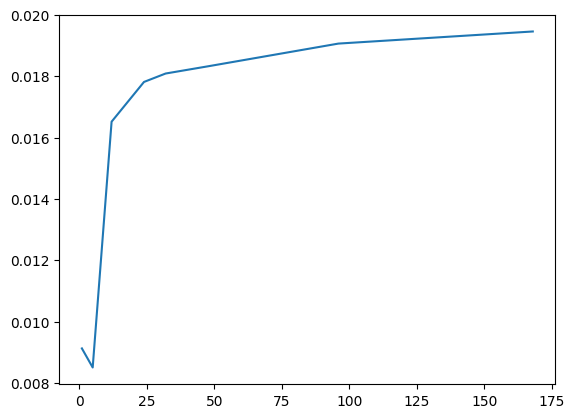

In [131]:
plt.plot(windows, qs)

In [132]:
HOLDING_WINDOW = 175

In [133]:
# Labels erstellen
labeled_data = create_labels(df_hour, window=HOLDING_WINDOW)

#dt_indicators.extend([f'EMA_{5}', f'EMA_{50}', f'EMA_{500}'])
# Liste der Indikatoren
#["SMA_50_Sig", "SMA_500_Sig", "HMA_50_Sig", "EMA_50_Sig", "EMA_500_Sig", "EMA_5_Sig"]#["OBV", "RSI_5", "RSI_10"]#, "RSI_50", "RSI_50", "MACD", "MACD_Signal", "Momentum_10", "StochRSI_10", "StochRSI_20", "StochRSI_50"]
features = dt_indicators

# Beste Indikatoren finden
best_model, best_combination, best_sharpe, train_sharpe_ratios, test_sharpe_ratios, models, combos = find_best_indicators(labeled_data, 
                                                                                                                        features, 
                                                                                                                        holding_period=HOLDING_WINDOW, 
                                                                                                                        target="label", 
                                                                                                                        signal_threshold=0.55,
                                                                                                                        plot=False)

('OBV',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000057, std=0.007398
Sharpe Ratio without costs: 0.007645862217046293
number of transactions 27
mean=0.000056, std=0.007398
Sharpe Ratio with costs: 0.0075868161713755515
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000036, std=0.001724
Sharpe Ratio without costs: 0.020737739178199977
number of transactions 4
mean=0.000035, std=0.001724
Sharpe Ratio with costs: 0.020582079622471987
('MACD',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000038, std=0.007529
Sharpe Ratio without costs: 0.005004486432188212
number of transactions 1
mean=0.000038, std=0.007529
Sharpe Ratio with costs: 0.005002375181987636
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000095, std=0.005385
Sharpe Ratio without cost

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_24_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_24',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000037, std=0.007530
Sharpe Ratio without costs: 0.004930145793098106
number of transactions 1
mean=0.000037, std=0.007530
Sharpe Ratio with costs: 0.0049279780757793355
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000096, std=0.005385
Sharpe Ratio without costs: 0.017756108713236914
number of transactions 1
mean=0.000096, std=0.005385
Sharpe Ratio with costs: 0.01774434798215525
('StochRSI_24',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000037, std=0.007529
Sharpe Ratio without costs: 0.004969687548984009
number of transactions 1
mean=0.000037, std=0.007529
Sharpe Ratio with costs: 0.004967532046616243
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000095, std=0.005385
Sharpe Ratio without costs: 0.01765682610141294
number of transactions 1
mean=0.000095, 

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_168_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_168',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000037, std=0.007529
Sharpe Ratio without costs: 0.004963477830565911
number of transactions 1
mean=0.000037, std=0.007529
Sharpe Ratio with costs: 0.004961343593362854
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000093, std=0.005383
Sharpe Ratio without costs: 0.01727161634772724
number of transactions 1
mean=0.000093, std=0.005383
Sharpe Ratio with costs: 0.017259343899203586
('StochRSI_168',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000037, std=0.007529
Sharpe Ratio without costs: 0.004970584380421249
number of transactions 3
mean=0.000037, std=0.007529
Sharpe Ratio with costs: 0.0049641157699777195
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000095, std=0.005385
Sharpe Ratio without costs: 0.01765682610141294
number of transactions 1
mean=0.000095,

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_720_Sig',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_720',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000036, std=0.007527
Sharpe Ratio without costs: 0.004743122126283325
number of transactions 3
mean=0.000036, std=0.007527
Sharpe Ratio with costs: 0.004736695049139268
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000092, std=0.005281
Sharpe Ratio without costs: 0.017405968720125557
number of transactions 3
mean=0.000092, std=0.005281
Sharpe Ratio with costs: 0.0173695720402334
('StochRSI_720',)
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000036, std=0.007520
Sharpe Ratio without costs: 0.004842398473167573
number of transactions 5
mean=0.000036, std=0.007520
Sharpe Ratio with costs: 0.00483173778894182
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000096, std=0.005385
Sharpe Ratio without costs: 0.017756108713236914
number of transactions 1
mean=0.000096, s

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'MACD')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000045, std=0.007498
Sharpe Ratio without costs: 0.005975909504984236
number of transactions 9
mean=0.000045, std=0.007498
Sharpe Ratio with costs: 0.005956621957409999
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000097, std=0.004570
Sharpe Ratio without costs: 0.02123069708003869
number of transactions 11
mean=0.000096, std=0.004571
Sharpe Ratio with costs: 0.021071653482783677
('OBV', 'RSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000051, std=0.007482
Sharpe Ratio without costs: 0.006800890293096803
number of transactions 19
mean=0.000051, std=0.007482
Sharpe Ratio with costs: 0.006759921733421336
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000075, std=0.003771
Sharpe Ratio without costs: 0.019892123666044988
number of transactions 19
mean=0.0000

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000037, std=0.007530
Sharpe Ratio without costs: 0.004930145793098106
number of transactions 1
mean=0.000037, std=0.007530
Sharpe Ratio with costs: 0.0049279780757793355
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000095, std=0.005385
Sharpe Ratio without costs: 0.01765682610141294
number of transactions 1
mean=0.000095, std=0.005385
Sharpe Ratio with costs: 0.017644928463227405
('SMA_24_Sig', 'StochRSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000037, std=0.007529
Sharpe Ratio without costs: 0.004969687548984009
number of transactions 1
mean=0.000037, std=0.007529
Sharpe Ratio with costs: 0.004967532046616243
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000095, std=0.005385
Sharpe Ratio without costs: 0.01765682610141294
number of transactions 1
me

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'HMA_168_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000037, std=0.007529
Sharpe Ratio without costs: 0.0049477756272287435
number of transactions 1
mean=0.000037, std=0.007529
Sharpe Ratio with costs: 0.004945628925583877
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000095, std=0.005385
Sharpe Ratio without costs: 0.01761802555577921
number of transactions 1
mean=0.000095, std=0.005385
Sharpe Ratio with costs: 0.017605907431176133
('SMA_24_Sig', 'StochRSI_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000038, std=0.007529
Sharpe Ratio without costs: 0.00498637714202993
number of transactions 1
mean=0.000038, std=0.007529
Sharpe Ratio with costs: 0.0049842476385259515
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000095, std=0.005385
Sharpe Ratio without costs: 0.01765682610141294
number of transactions 1
m

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'HMA_720_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_720')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000037, std=0.007527
Sharpe Ratio without costs: 0.004857738540627861
number of transactions 1
mean=0.000037, std=0.007527
Sharpe Ratio with costs: 0.004855618189411778
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000099, std=0.005346
Sharpe Ratio without costs: 0.018555543349337976
number of transactions 3
mean=0.000099, std=0.005346
Sharpe Ratio with costs: 0.018518399734230768
('SMA_24_Sig', 'StochRSI_720')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000037, std=0.007529
Sharpe Ratio without costs: 0.0049564240378612125
number of transactions 1
mean=0.000037, std=0.007529
Sharpe Ratio with costs: 0.004954273095098168
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000096, std=0.005385
Sharpe Ratio without costs: 0.017756108713236914
number of transactions 1

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000060, std=0.007291
Sharpe Ratio without costs: 0.00817768363897216
number of transactions 37
mean=0.000059, std=0.007291
Sharpe Ratio with costs: 0.008095647711830866
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000056, std=0.004958
Sharpe Ratio without costs: 0.011392152734542502
number of transactions 11
mean=0.000056, std=0.004958
Sharpe Ratio with costs: 0.011247681068592886
('EMA_24_Sig', 'HMA_24_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs:

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


In [134]:
res = pd.DataFrame.from_dict({"test":test_sharpe_ratios, 
                              "train":train_sharpe_ratios})
q = res["test"].quantile(0.8)

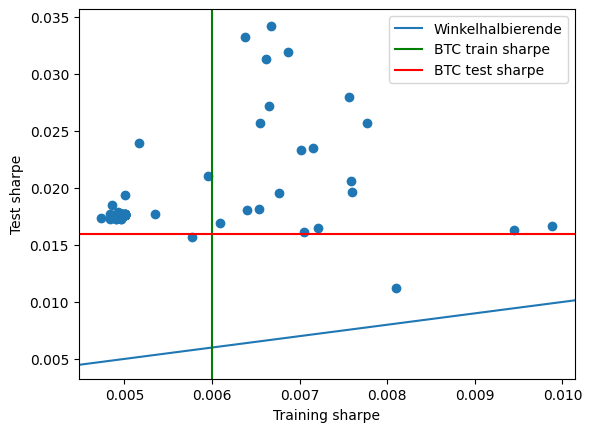

In [135]:
fig, ax = plt.subplots()

ax.scatter(train_sharpe_ratios, test_sharpe_ratios)
ax.axline((min(train_sharpe_ratios), min(train_sharpe_ratios)), slope=1, label="Winkelhalbierende")

train_btc_sharpe=0.006
test_btc_sharpe=0.016  
plt.axvline(x=train_btc_sharpe, color='g', linestyle='-', label="BTC train sharpe")
plt.axhline(y=test_btc_sharpe, color='r', linestyle='-', label="BTC test sharpe")

ax.set_xlabel("Training sharpe")
ax.set_ylabel("Test sharpe")
ax.legend()

In [157]:
# Indices which have above average training and test sharpe ratios
interesting_indices = [idx for idx, val in enumerate(test_sharpe_ratios) if val > test_btc_sharpe and train_sharpe_ratios[idx] > train_btc_sharpe]
res["model_score"] = res["test"] - test_btc_sharpe + res["train"] - train_btc_sharpe
res.iloc[interesting_indices].sort_values("model_score", ascending=False)

,test,train,model_score
31,0.034227,0.006678,0.018906
38,0.033274,0.006378,0.017652
25,0.031909,0.006870,0.016779
26,0.031314,0.006622,0.015936
29,0.028011,0.007569,0.013580
42,0.027174,0.006646,0.011819
41,0.025703,0.007768,0.011470
28,0.025683,0.006544,0.010227
30,0.023518,0.007156,0.008674
33,0.023321,0.007013,0.008334


# Select model

In [158]:
idx=31
print(combos[idx])
THRESHOLD = 0.5

['OBV', 'EMA_168_Sig']


In [159]:
models[idx]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000044, std=0.007483
Sharpe Ratio without costs: 0.005921027491280586
number of transactions 21
mean=0.000044, std=0.007483
Sharpe Ratio with costs: 0.005875749143296992
pred
1    30150
0      893
Name: count, dtype: int64


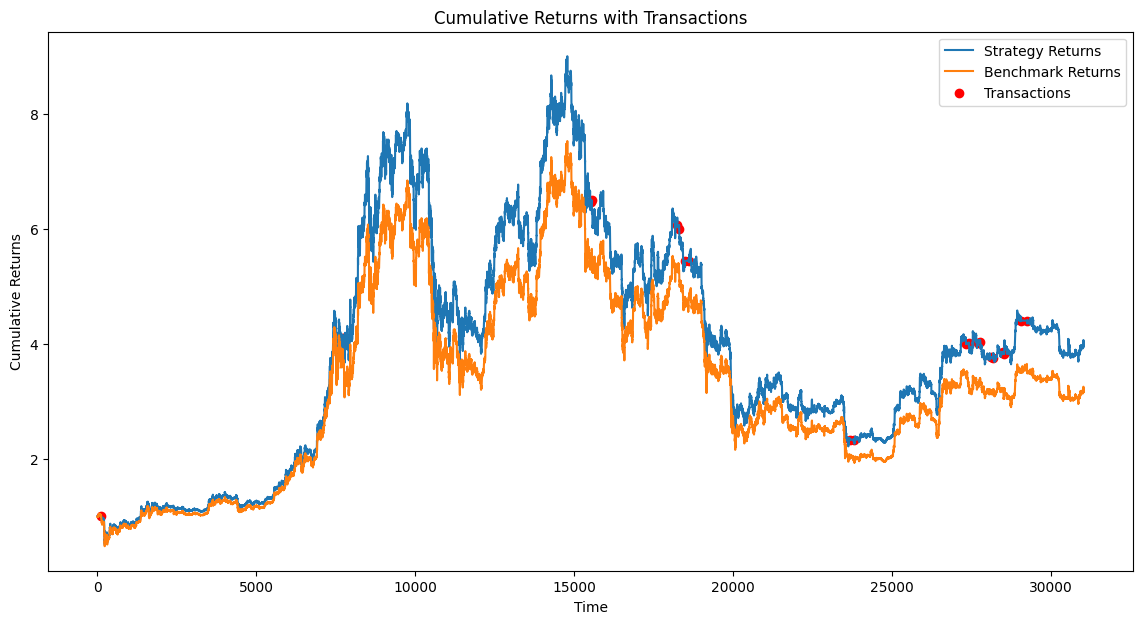

mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000072, std=0.003075
Sharpe Ratio without costs: 0.023435242532682272
number of transactions 9
mean=0.000071, std=0.003074
Sharpe Ratio with costs: 0.02325530917050128
pred
0    4914
1    2847
Name: count, dtype: int64


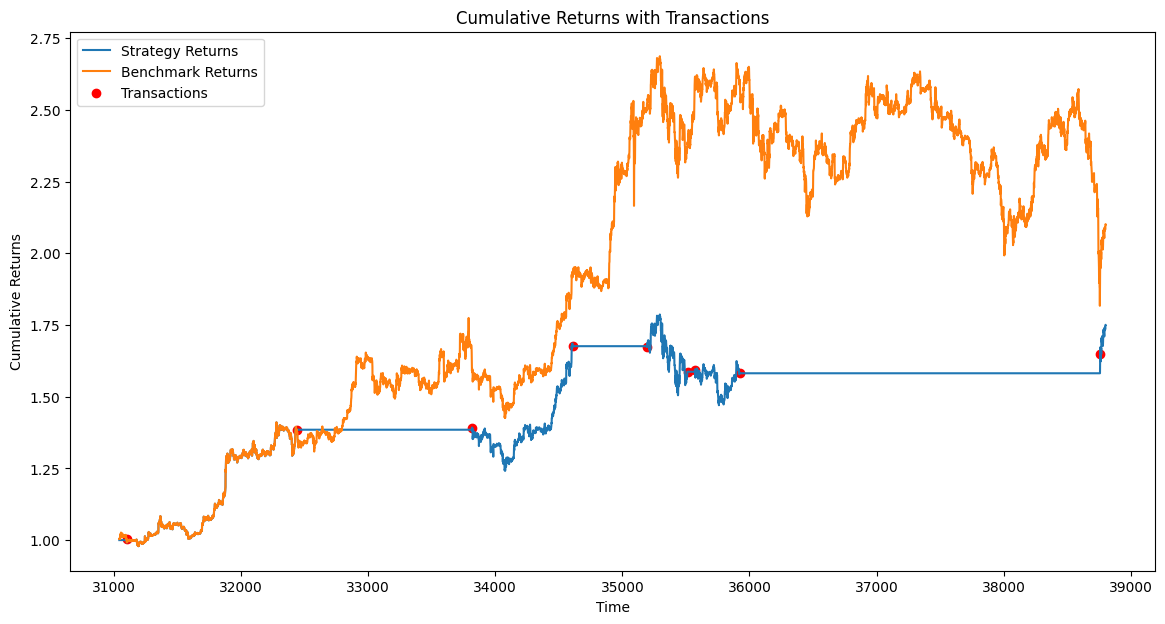

np.float64(0.02325530917050128)

In [160]:
_, X_test, X_train = train_model(data=labeled_data, features=combos[idx], target="label", param_grid={}, estimator=DecisionTreeClassifier(random_state=42))

evaluate_model(X_train, models[idx], data=labeled_data, signal_threshold=THRESHOLD, holding_period=HOLDING_WINDOW, plot=True)
evaluate_model(X_test, models[idx], data=labeled_data, signal_threshold=THRESHOLD, holding_period=HOLDING_WINDOW, plot=True)

# Single Model Analysis

In [161]:
clf = models[idx]
th = 0.5
sharpe = evaluate_model(X_train, clf, data=labeled_data, signal_threshold=th, holding_period=HOLDING_WINDOW, plot=False)

mean=0.000037, std=0.007530
Sharpe BTC 0.004930145793098106
mean=0.000044, std=0.007483
Sharpe Ratio without costs: 0.005921027491280586
number of transactions 21
mean=0.000044, std=0.007483
Sharpe Ratio with costs: 0.005875749143296992


In [162]:
sharpe = evaluate_model(X_test, clf, data=labeled_data, signal_threshold=th, holding_period=HOLDING_WINDOW, plot=False)

mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000072, std=0.003075
Sharpe Ratio without costs: 0.023435242532682272
number of transactions 9
mean=0.000071, std=0.003074
Sharpe Ratio with costs: 0.02325530917050128


In [163]:
from functools import partial

plot_func = partial(evaluate_model, X_test=X_test, best_clf=clf, data=labeled_data, holding_period=HOLDING_WINDOW, plot=False)
xs = np.arange(0.5, 1, 0.05)
ys = np.ndarray(shape=len(xs))
for i in range(len(xs)):
     ys[i] = plot_func(signal_threshold=xs[i])

mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000072, std=0.003075
Sharpe Ratio without costs: 0.023435242532682272
number of transactions 9
mean=0.000071, std=0.003074
Sharpe Ratio with costs: 0.02325530917050128
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000073, std=0.002135
Sharpe Ratio without costs: 0.03434984195680392
number of transactions 4
mean=0.000073, std=0.002135
Sharpe Ratio with costs: 0.03422741613677549
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000040, std=0.001668
Sharpe Ratio without costs: 0.024018159350920075
number of transactions 4
mean=0.000040, std=0.001668
Sharpe Ratio with costs: 0.023861766517782327
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914
mean=0.000034, std=0.001607
Sharpe Ratio without costs: 0.021011388600072112
number of transactions 6
mean=0.000033, std=0.001607
Sharpe Ratio with costs: 0.020770304713777558
mean=0.000096, std=0.005385
Sharpe BTC 0.017756108713236914

C:\Users\Adria\AppData\Local\Temp\ipykernel_5888\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Text(0, 0.5, 'sharpe')

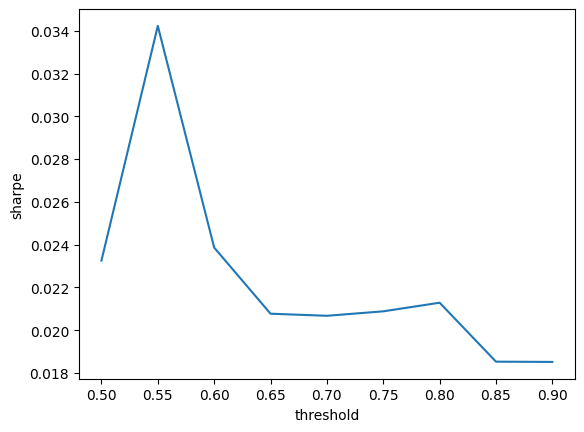

In [164]:
plt.plot(xs, ys)
plt.xlabel("threshold")
plt.ylabel("sharpe")

In [82]:
_ = tree.plot_tree(clf)

InvalidParameterError: The 'decision_tree' parameter of plot_tree must be an instance of 'sklearn.tree._classes.DecisionTreeClassifier' or an instance of 'sklearn.tree._classes.DecisionTreeRegressor'. Got XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...) instead.

In [ ]:
# Iterate over 3-month periods
start_date = df_hour.index.min()
end_date = df_hour.index.max()

# Create plots for each 3-month period
while start_date < end_date:
    # Define the end date of the current 3-month period
    current_end_date = start_date + pd.DateOffset(months=3)
    
    # Slice the data for the current 3-month period
    df_slice = df_hour[(df_hour.index >= start_date) & (df_hour.index < current_end_date)]
    a = 24*365
    # Plot
    plt.figure(figsize=(16, 6))
    df_slice[["Close", "SMA_500", "SMA_100", "EMA_100", "EMA_500", "SMA_50", "EMA_50", f'SMA_{a}']].plot(ax=plt.gca())
    plt.title(f'Close Price and SMAs from {start_date.date()} to {current_end_date.date()}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()
    
    # Move to the next 3-month period
    start_date = current_end_date

TypeError: unsupported operand type(s) for +: 'int' and 'DateOffset'